In [4]:
import numpy as np
import folium
import glob, os  
from folium.plugins import MarkerCluster
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
from pandas import Series
from sklearn.metrics import mean_squared_error
from math import sqrt
from fbprophet import Prophet
from numpy import log
plt.style.use('fivethirtyeight')
%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
air_visit_data = pd.read_csv("data/air_visit_data.csv")

In [4]:
air_visit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
air_store_id    252108 non-null object
visit_date      252108 non-null object
visitors        252108 non-null int64
dtypes: int64(1), object(2)
memory usage: 5.8+ MB


In [5]:
air_visit_data[air_visit_data.visitors==0]

Empty DataFrame
Columns: [air_store_id, visit_date, visitors]
Index: []

In [7]:
groupn=set(air_visit_data.air_store_id)
groupn=np.array(list(groupn))

In [8]:
groupn.sort()

In [9]:
len(groupn)

829

In [46]:
# divide data of visitors for each store
for name, g in air_visit_data.groupby('air_store_id'):
    h=g[['visit_date','visitors']]
    h.to_csv('public/{}.csv'.format(name),index_label=False,index=False)

Create a new dieectory, public, to store the splited data files:

In [10]:
test=pd.read_csv("public/{}.csv".format(groupn[0]))

In [11]:
test.columns=['ds','y']

In [12]:
m = Prophet()  
m.fit(test) 

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future_data = m.make_future_dataframe(periods=30)
forecast = m.predict(future_data)
# rest negative yhat to zero
forecast.yhat[forecast['yhat']<0]=0
forecast1=forecast['yhat'].tail(30) 


In [9]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 16 columns):
ds                     262 non-null datetime64[ns]
trend                  262 non-null float64
trend_lower            262 non-null float64
trend_upper            262 non-null float64
yhat_lower             262 non-null float64
yhat_upper             262 non-null float64
seasonal               262 non-null float64
seasonal_lower         262 non-null float64
seasonal_upper         262 non-null float64
seasonalities          262 non-null float64
seasonalities_lower    262 non-null float64
seasonalities_upper    262 non-null float64
weekly                 262 non-null float64
weekly_lower           262 non-null float64
weekly_upper           262 non-null float64
yhat                   262 non-null float64
dtypes: datetime64[ns](1), float64(15)
memory usage: 32.8 KB


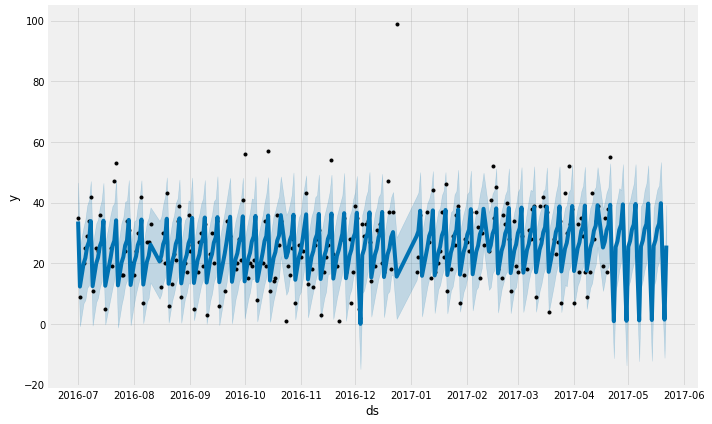

In [10]:
m.plot(forecast);  

### Uncertainty in the trend
The biggest source of uncertainty in the forecast is the potential for future trend changes. The time series we have seen already in this documentation show clear trend changes in the history. Prophet is able to detect and fit these, but what trend changes should we expect moving forward? It's impossible to know for sure, so we do the most reasonable thing we can, and we assume that the *future will see similar trend changes as the history*. In particular, we assume that the average frequency and magnitude of trend changes in the future will be the same as that which we observe in the history. We project these trend changes forward and by computing their distribution we obtain uncertainty intervals.

One property of this way of measuring uncertainty is that allowing higher flexibility in the rate, by increasing `changepoint_prior_scale`, will increase the forecast uncertainty. This is because if we model more rate changes in the history then we will expect more in the future, and makes the uncertainty intervals a useful indicator of overfitting.

The width of the uncertainty intervals (by default 80%) can be set using the parameter `interval_width`:

In [83]:
m95 = Prophet(interval_width=0.95)
forecast95 =m95 .fit(test).predict(future_data)  


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


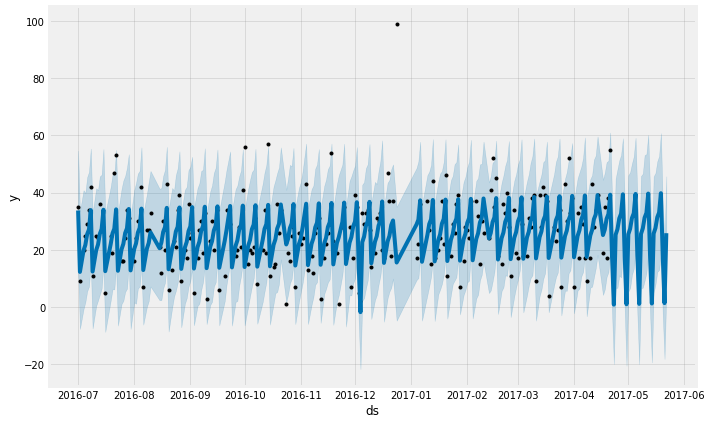

In [86]:
m95.plot(forecast95);

In [10]:
# select the days which are holidays, and create it as holidys dataframe
day_info= pd.read_csv("data/date_info.csv")
days=day_info[day_info['holiday_flg']==1]['calendar_date']

In [ ]:
times=np.array(days.astype('str'))

In [11]:
# setup the holidays option

holidays = pd.DataFrame({  
  'holiday': 'holiday',
  'ds': pd.to_datetime(days.values),
  'lower_window': 0,
  'upper_window': 1,
})

In [59]:
# select the days which are holidays, and create it as holidys dataframe
#day_info= pd.read_csv("data/date_info.csv")
#days=day_info[day_info['holiday_flg']==1]['calendar_date']
holidays_mc = pd.DataFrame({  
  'holiday': 'holiday',
  'ds': pd.to_datetime(days.values),
  'lower_window': -1,
  'upper_window': 1, 
  'holidays_prior_scale':20,  
})

In [13]:
# recreate prophet with holidays effect under consideration
m2 = Prophet(holidays=holidays)  
m2.fit(test) 

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
future_data2 = m2.make_future_dataframe(periods=30)  
forecast2 = m2.predict(future_data2)  
forecast2.yhat[forecast2['yhat']<0]=0

In [15]:
forecast230=forecast2['yhat'].tail(30) 
dt=forecast['ds'].tail(30)


In [74]:
# recreate prophet with holidays effect under consideration
m3 = Prophet(holidays=holidays,holidays_prior_scale=0.05)#,mcmc_samples=500)  
m3.fit(test) 

future_data3 = m3.make_future_dataframe(periods=30)  
forecast3 = m3.predict(future_data3)  
forecast3.yhat[forecast3['yhat']<0]=0

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [75]:
forecast330=forecast3['yhat'].tail(30) 

In [62]:
dss=pd.to_datetime(dt).apply(lambda x:x.strftime('%Y-%m-%d'))


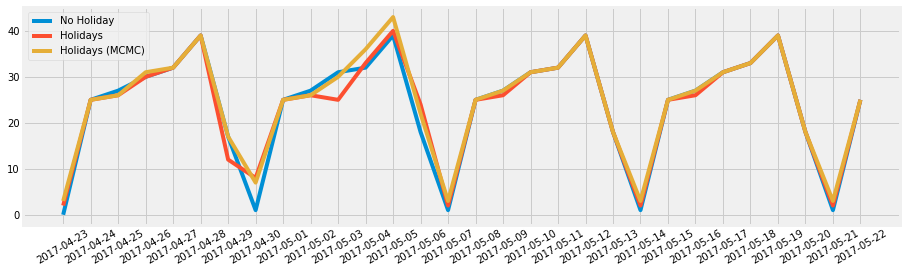

In [76]:
plt.figure(figsize=(14,4))
plt.plot(dss,forecast1.astype(int),label='No Holiday')
plt.plot(dss,forecast230.astype(int),label='Holidays')
plt.plot(dss,forecast330.astype(int),label='Holidays (MCMC)')

plt.xticks(rotation=30)
plt.legend();
plt.grid(True)

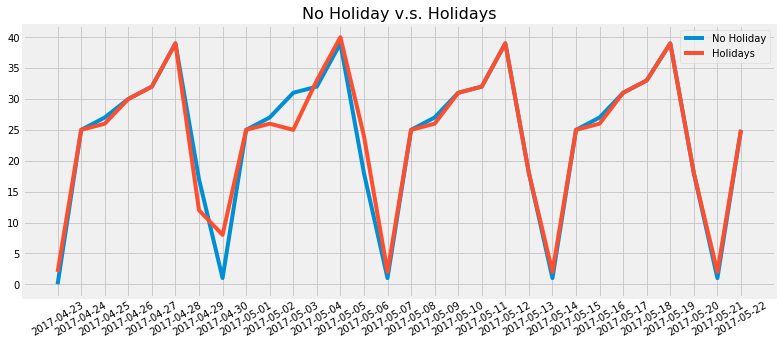

In [73]:
from matplotlib.dates import YEARLY, DateFormatter, rrulewrapper, RRuleLocator, drange

rule = rrulewrapper(YEARLY, byeaster=1, interval=5)
loc = RRuleLocator(rule)
formatter = DateFormatter('%Y-%m-%d')

fig, ax = plt.subplots(figsize=(12,5))
plt.plot(dss,forecast1.astype(int),label='No Holiday')
plt.plot(dss,forecast230.astype(int),label='Holidays')

#ax.xaxis.set_major_locator(loc)
#ax.xaxis.set_major_formatter(formatter)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)
#plt.xticks(days.values[-4:],rotation=30)
plt.title("No Holiday v.s. Holidays",size=16)
plt.legend();
plt.grid(True)

In [51]:
dt[232]

Timestamp('2017-04-23 00:00:00')

In [43]:
dd=np.array([i] for i in dt.values)

In [54]:
dd=dss.reshape(1,dss.size)

In [60]:
ddays=days[-4:].reshape(1,4)

In [69]:
dd[0].astype(str),ddays[0]

(array(['2017-04-23', '2017-04-24', '2017-04-25', '2017-04-26',
        '2017-04-27', '2017-04-28', '2017-04-29', '2017-04-30',
        '2017-05-01', '2017-05-02', '2017-05-03', '2017-05-04',
        '2017-05-05', '2017-05-06', '2017-05-07', '2017-05-08',
        '2017-05-09', '2017-05-10', '2017-05-11', '2017-05-12',
        '2017-05-13', '2017-05-14', '2017-05-15', '2017-05-16',
        '2017-05-17', '2017-05-18', '2017-05-19', '2017-05-20',
        '2017-05-21', '2017-05-22'],
       dtype='<U10'),
 array(['2017-04-29', '2017-05-03', '2017-05-04', '2017-05-05'], dtype=object))

In [44]:
times=np.array([ '2017-04-29', '2017-04-30',
        '2017-05-01', '2017-05-02', '2017-05-03', '2017-05-04',
        '2017-05-05', '2017-05-06', '2017-05-07', '2017-05-08',
        '2017-05-09', '2017-05-10', '2017-05-11', '2017-05-12',
        '2017-05-13', '2017-05-14', '2017-05-15', '2017-05-16',
        '2017-05-17', '2017-05-18', '2017-05-19', '2017-05-20',
        '2017-05-21', '2017-05-22'])

In [63]:
plt.vlines?

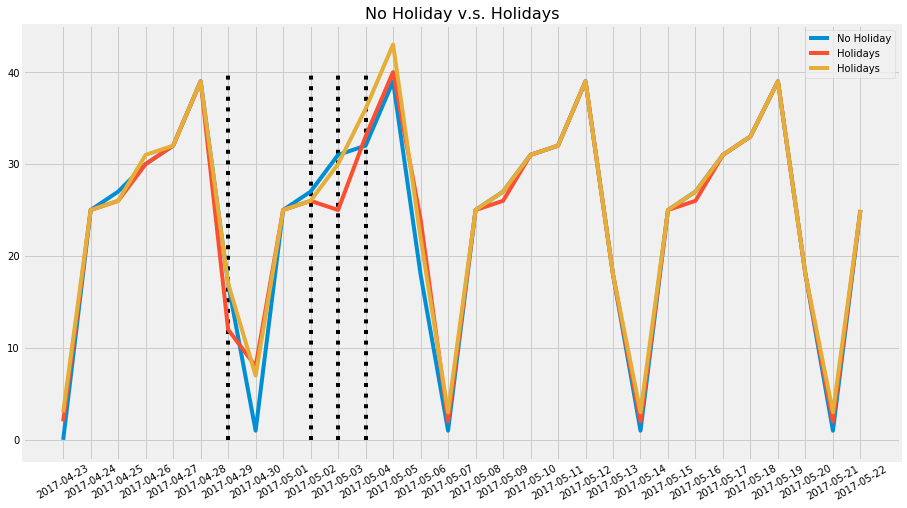

In [77]:
fig, ax = plt.subplots(figsize=(14,8))

plt.plot(dss,forecast1.astype(int),label='No Holiday')
plt.plot(dss,forecast230.astype(int),label='Holidays')
plt.plot(dss,forecast330.astype(int),label='Holidays')
#plt.xticks(days.values[-4:],rotation=30)

plt.vlines(['2017-04-29'] ,0,40, linestyles='dotted')
plt.vlines(['2017-05-02'] ,0,40, linestyles='dotted')
plt.vlines(['2017-05-03'] ,0,40, linestyles='dotted')
plt.vlines(['2017-05-04'] ,0,40, linestyles='dotted')
#plt.xticks(ddays[0].astype(str),rotation=30)
plt.xticks(dss,rotation=30)
plt.title("No Holiday v.s. Holidays",size=16)
plt.legend();
plt.grid(True)

In [65]:
import plotly.graph_objs as go
import numpy as np
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode()

In [71]:
ind_n=-30
forecast_1=go.Scatter(x=forecast['ds'],y=forecast['yhat'].astype(int),name='No Holiday')
forecast_2=go.Scatter(x=forecast2['ds'],y=forecast2['yhat'].astype(int),name='Holiday')
forecast_3=go.Scatter(x=forecast3['ds'],y=forecast3['yhat'].astype(int),name='Holiday II')
data = [forecast_1,forecast_2,forecast_3]

In [72]:
iplot(data)

In [58]:
def RMSLE(y,yhat):
    Sum=0

    for i in range(len(y)):
        yhat[yhat<0]=0
        Sum+=(log(y[i]+1)-log(yhat[i]+1))**2
    return np.sqrt(Sum/len(y)) 

In [23]:
def RMSLE_vec(y,yhat):
    Sum=0
    yhat[yhat<0]=0
    Sum=np.sum((log(y+1)-log(yhat+1))**2)
    
    return np.sqrt(Sum/len(y)) 

In [22]:
RMSLE_vec(test['y'], forecast2[:-30]['yhat'])

/Users/cch/anaconda36/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/cch/anaconda36/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.45426135616208435

In [60]:
df_test=forecast[['ds','yhat']]

In [61]:
df_test['yhat']=df_test['yhat'].astype(int)
#for i in range(len(df_test)):
#    df_test['dt'][i]='{}_{}'.format(groupn[0],df_test['ds'][i])

In [62]:
# store data as follows competition's rule 
df_test['ds']=pd.to_datetime(df_test['ds']).apply(lambda x:'{}-{}'.format(groupn[0],x.strftime('%Y-%m-%d')))

Create new directory, private, to put the files of predicted data: 

In [63]:
name=groupn[0]
df_test.columns=['id','visitors']
df_test.to_csv('private/{}.csv'.format(name),index_label=True,index=False)

In [64]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 2 columns):
id          262 non-null object
visitors    262 non-null int64
dtypes: int64(1), object(1)
memory usage: 4.2+ KB


In [34]:
def makefbprophet(data,datenum=39):
    m = Prophet(yearly_seasonality=True,daily_seasonality=True)
    m.fit(data)
    future_data = m.make_future_dataframe(periods=39)
    forecast = m.predict(future_data)
    forecast.yhat[forecast['yhat']<0]=0
    df_test=forecast[['ds','yhat']]
    df_test['yhat']=df_test['yhat'].astype(int)
    df_test['ds']=pd.to_datetime(df_test['ds']).apply(lambda x:'{}-{}'.format(groupn[0],x.strftime('%Y-%m-%d')))
    df_test.columns=['id','visitors']
    return df_test[-datenum:]

def fbprophetfile(input):
    groupn=set(air_visit_data.air_store_id)
    groupn=np.array(list(groupn))
    groupn.sort()
    filenum=len(groupn)
    InputFiles=input+"/*.csv" 
    for i in range(filenum):
        test=pd.read_csv(input+"/"+groupn[i]+".csv")
        test.columns=['ds','y']
        df_test=makefbprophet(test)

        df_test.to_csv('private/{}.csv'.format(groupn[i]),index_label=True,index=False)

In [35]:
fbprophetfile('public')

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 15.0.


In [33]:
files=glob.glob("private/*.csv")
len(files)
#for file in files:
#    print(file)

829

Combine CSV's
---

In [28]:

def combine(dir,name="combine.csv"):
    """
    input:
       combine(directory,name="combine.csv")
    output:
       combine.csv
    """
    df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('private', "*.csv"))))
    df.to_csv('{}'.format(name),index_label=False,index=False)
    print("CSV had been combined as combine.csv.")

In [36]:
combine('private',name='combine1.csv')

CSV had been combined as combine.csv.
